# Fitting a line to data using MCMC

In this example we will be going over Exercise 6 from [Hogg 2010](http://arxiv.org/abs/1008.4686).  We will be fitting a line to data using a model that rejects outliers using an MCMC sampler.

## Packages being used
+ `numpy`: doing math on arrays
+ `numpyro`: this does the heavy lifting for the MCMC code
+ `matplotlib`: plot our results
+ `python-graphviz`: plotting pymc models as graphs
+ `pandas`: read in data table

## Relevant documentation
+ introduction to probabilistic programming: https://nbviewer.jupyter.org/github/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers/blob/master/Prologue/Prologue.ipynb
+ `matplotlib`: https://matplotlib.org/stable/api/pyplot_summary.html
+ how to pick priors: https://github.com/stan-dev/stan/wiki/Prior-Choice-Recommendations
+ introduction to numpyro for astronomers: https://dfm.io/posts/intro-to-numpyro/

In [1]:
import numpy as np
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpyro
import numpyro.distributions as dist
import numpyro.infer as infer
import arviz
import pandas
import mpl_style

%matplotlib inline
plt.style.use(mpl_style.style1)

# Tell numpyro to use each CPU core as a different "device"
numpyro.set_host_device_count(4)


### Read in the data
First lets read in the data we will be fitting:

In [2]:
data = pandas.read_csv('data.csv')

x_mean = data.x.mean()
x_std = data.x.std()
y_mean = data.y.mean()
y_std = data.y.std()

# center and scale data
x_center = jnp.array((data.x - x_mean) / x_std)
y_center = jnp.array((data.y - y_mean) / y_std)
sy_center = jnp.array(data.sy / y_std)
sx_center = jnp.array(data.sx / x_std)

# data order
idx = data.x.argsort()


def un_center(b0_prime, b1_prime, x_mean, x_std, y_mean, y_std):
    b0 = (b0_prime * y_std) - (b1_prime * x_mean * y_std/x_std) + y_mean
    x = x_mean - (x_std / b1_prime) * ((y_mean / y_std) + b0_prime)
    b1 = -b0 / x
    return b0, b1


### What does centering the data do?
We will be fitting a line to our data with a slope and an intercept.  In the original data space these two value are highly correlated, a small change in slope will result in a large change in the intercept and vice-versa.  By centering and scaling the data we are ensuring the intercept is close to 0 and the `x` and `y` values are about the same size.  This reduces the correlation between the two fit parameters (e.g. you can adjust the slope and keep the intercept the same).

### Plot the data
Lets take a look at our data to see what we are fitting:

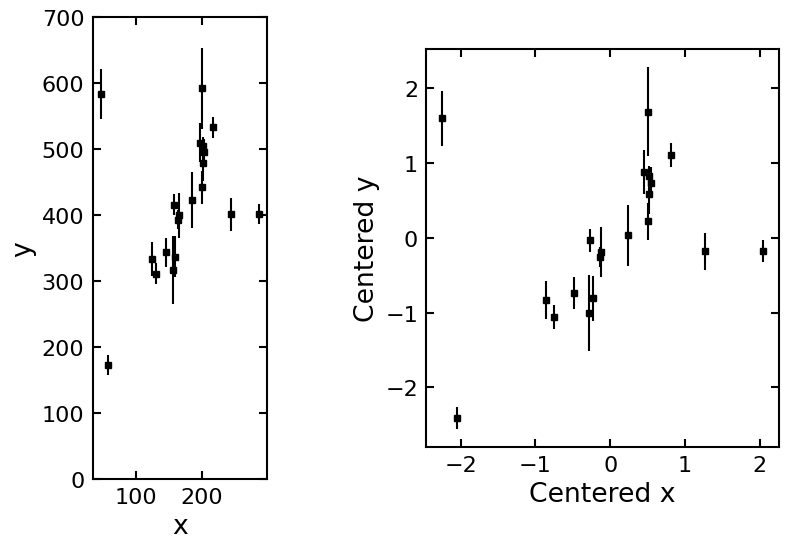

In [3]:
errorbar_kwargs = {
    'ls': 'None',
    'mfc': 'k',
    'mec': 'k',
    'ms': 5,
    'marker': 's',
    'ecolor': 'k'
}

plt.figure(1, figsize=(10, 6))
ax1 = plt.subplot2grid((1, 2), (0, 0))
ax1.errorbar(data.x, data.y, data.sy, **errorbar_kwargs)
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.set_ylim(0, 700)
ax1.set_aspect(1)

ax2 = plt.subplot2grid((1, 2), (0, 1))
ax2.errorbar(x_center, y_center, sy_center, **errorbar_kwargs)
ax2.set_xlabel('Centered x')
ax2.set_ylabel('Centered y')
ax2.set_aspect(1);


## OLS Model
As a starting point we will first build a least squares linear regression model and see how that does.  To help the sampler out a bit we will use the angle of the line and the perpendicular offset instead of slope and y-intercept.

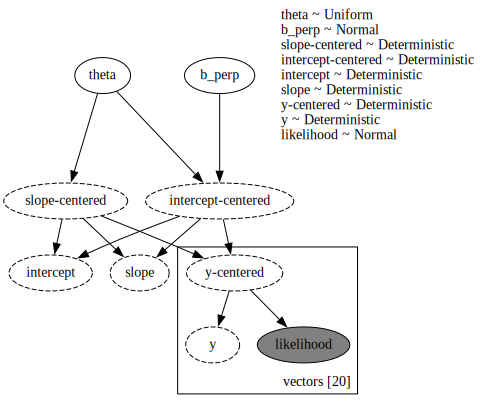

In [4]:
def mdl_ols():
    theta = numpyro.sample('theta', dist.Uniform(-0.5 * jnp.pi, 0.5 * jnp.pi))
    b_perp = numpyro.sample('b_perp', dist.Normal(0.0, 10.0))

    # convert to centered slope and intercept
    b1 = numpyro.deterministic('slope-centered', jnp.tan(theta))
    b0 = numpyro.deterministic('intercept-centered', b_perp / jnp.cos(theta))

    # un-center slope and intercept as Deterministic variables so we can plot them later
    b0_orig, b1_orig = un_center(b0, b1, x_mean, x_std, y_mean, y_std)
    numpyro.deterministic('intercept', b0_orig)
    numpyro.deterministic('slope', b1_orig)

    with numpyro.plate(f'vectors [{len(y_center)}]', len(y_center)):
        y_est_centered = numpyro.deterministic('y-centered', b0 + b1 * x_center)
        # un-center y_est for plotting later on
        numpyro.deterministic('y', (y_est_centered * y_std) + y_mean)

        # Likelihood
        numpyro.sample('likelihood', dist.Normal(y_est_centered, sy_center), obs=y_center)

numpyro.render_model(mdl_ols, render_distributions=True)


We can see the likelihood of the fit given the data is defined as a Normal distribution with scatter defined by observed y-errors.  The prior chosen for the angle is uniform from -90 to 90 and the perpendicular offset uses a weakly informative Normal prior.

### Run HMC
Now we can run the HMC sampler to find the best fit.

In [5]:
# Set a random seed
rng_key = jax.random.PRNGKey(0)


In [6]:
# Rotate the random seed
rng_key, rng_key_ = jax.random.split(rng_key)

kernel = infer.NUTS(mdl_ols)
mcmc = infer.MCMC(kernel, num_warmup=1000, num_samples=1000, num_chains=4)
mcmc.run(rng_key_)


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

The default sampler is NUTS (No U-True Sampler), a powerful sampler that uses the likelihood's gradient information to propose new MC steps. 

### Check for convergence
Lets look at the results and see if HMC converged:

In [7]:
traces_ols = arviz.from_numpyro(mcmc)

print(f'divergences: {traces_ols.sample_stats.diverging.values.sum()}')
arviz.summary(
    traces_ols,
    var_names=['intercept', 'slope']
)


divergences: 0


mean      sd   hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
intercept  214.442  14.158  188.895  241.904      0.231    0.164    3776.0   
slope        1.072   0.077    0.929    1.216      0.001    0.001    3662.0   

           ess_tail  r_hat  
intercept    3025.0    1.0  
slope        2694.0    1.0

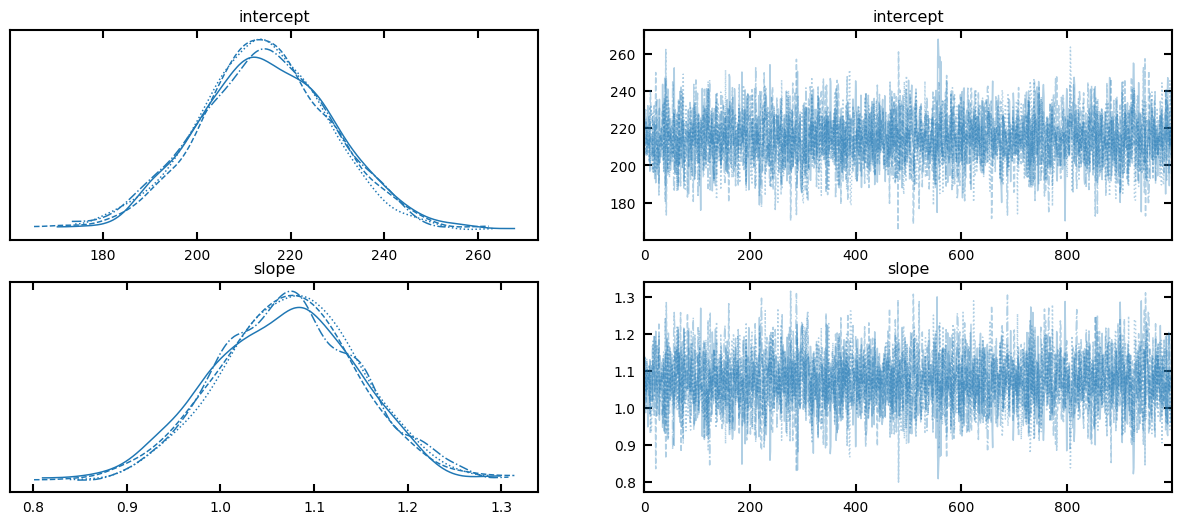

In [8]:
arviz.plot_trace(
    traces_ols,
    figsize=(15, 6),
    var_names=['intercept', 'slope']
);


Everything looks good, the `Rhat` values are all close to 1, and the traces have all mixed well.  Since we named the `y_est` variable it is also tracked in every sampling step.  This makes plotting the results easier since we don't need to evaluate the model for every `b0` and `b1` value in the sample.

Lets take a look at the covariance between the fitted intercept and slope.

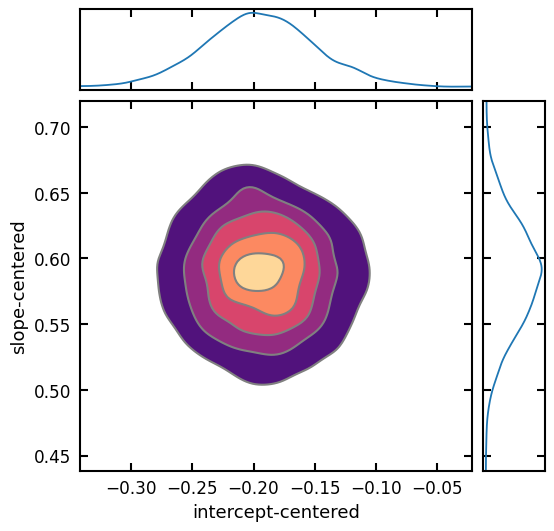

In [9]:
ax = arviz.plot_pair(
    traces_ols,
    var_names=['intercept-centered', 'slope-centered'],
    marginals=True,
    kind='kde',
    figsize=[6, 6]
)


Notice how in the centered parameter space these two values are not correlated (as expected), let transform the fit back to the original data space.

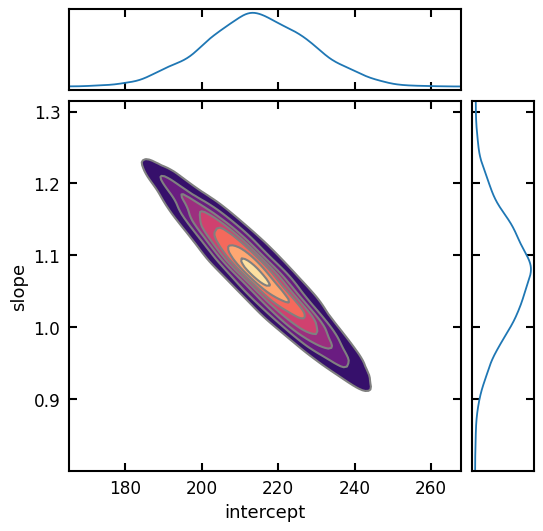

In [10]:
ax = arviz.plot_pair(
    traces_ols,
    var_names=['intercept', 'slope'],
    marginals=True,
    kind='kde',
    figsize=[6, 6]
)


Now we can see a large correlation in the fit parameters.  If we tried to run the HMC sampler in this data space it could have issues.

### Plotting the best fit
Finally we can plot the best fit on the original data.

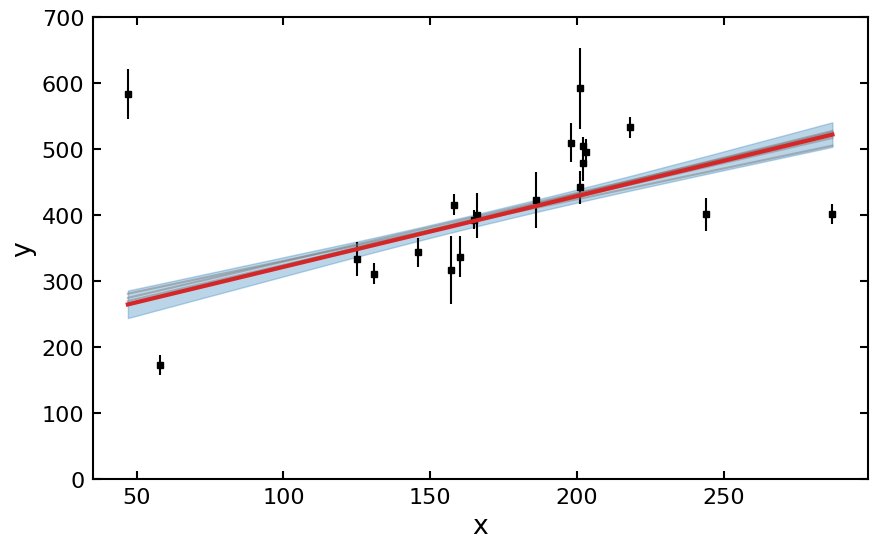

In [11]:
fill_kwargs = {
    'color': 'C0',
    'alpha': 0.3,
    'zorder': 1
}

# grab un-centered y-values from the sampler
y_est = traces_ols.posterior.y.data.reshape(-1, 20)

# plot original data
plt.figure(2, figsize=(10, 6))
plt.errorbar(data.x, data.y, data.sy, **errorbar_kwargs)

# find 2-sigma and median of best fit lines
y_est_minus_2_sigma, y_est_median, y_est_plus_2_sigma = np.percentile(
    y_est[:, idx],
    [2.5, 50, 97.5],
    axis=0
)

# plot the median of all best fit lines
plt.plot(data.x[idx], y_est_median, color='C3', lw=3, zorder=3)

# plot 2-sigma best fit region
plt.fill_between(data.x[idx], y_est_minus_2_sigma, y_est_plus_2_sigma, **fill_kwargs)

# plot a selection of best fit lines
plt.plot(data.x[idx], y_est[::800].T[idx], alpha=0.5, color='C7')

plt.xlabel('x')
plt.ylabel('y')
plt.ylim(0, 700);


From this plot we can see that the fitted line is being effected by several outliers in the data. Lets build a model that will filter out these outliers.

## Mixture model

The likelihood we need for this fit is shown in equation 13 of [Hogg 2010](http://arxiv.org/abs/1008.4686):

$$\mathscr{L} \propto \prod_{i=1}^{N}{\left[\frac{1}{\sqrt{2 \pi \sigma_{yi}^{2}}} \exp{\left(-\frac{[y_{i} - m x_{i} - b]^2}{2 \sigma_{yi}^{2}}\right)}\right]^{[1-q_{i}]} \times \left[\frac{1}{\sqrt{2 \pi [V_{b}+\sigma_{yi}^{2}]}} \exp{\left( -\frac{[y_{i} - Y_{b}]^2}{2[V_{b}+\sigma_{yi}^{2}]} \right)} \right]^{q_{i}}}$$

$$\{q_{i}\} \sim \text{Bernoulli}(P_b) $$

where $x_{i}, y_{i}, \sigma_{yi}$ are the data from the `.csv` file, $m, b$ are the slope and intercept of the line we are fitting, $q_{i}$ is $1$ if a point is an outlier and $0$ otherwise.  The set of these flags follow a Bernoulli distribution with a probability of being an outlier of $P_b$.  $Y_{b}, V_{b}$ are the parameters of the distribution the outliers are draw from.

To use this directly we would need to have the $q_{i}$'s be discrete values, but the HMC sampler we are using only works for continuous values.  To get around this we can marginalize over the individual $q_{i}$ values (i.e. do the integration by hand) and get a likelihood that only uses continuous variables.  See section 3 of Hogg's paper for a full derivation.

$$\mathscr{L} \propto \prod_{i=1}^{N}{\left[\frac{1-P_{b}}{\sqrt{2 \pi \sigma_{yi}^{2}}} \exp{\left(-\frac{[y_{i} - m x_{i} - b]^2}{2 \sigma_{yi}^{2}}\right)} + \frac{P_{b}}{\sqrt{2 \pi [V_{b}+\sigma_{yi}^{2}]}} \exp{\left( -\frac{[y_{i} - Y_{b}]^2}{2[V_{b}+\sigma_{yi}^{2}]} \right)} \right]}$$

Since we will be using a Bayesian approach to this fitting, we need to define priors for our fit parameters $\theta = \left[ m, b, P_b, Y_b, V_b \right]$.  We will use weakly informative priors in all the parameters.

As a bonus, it turns out that the $q_{i}$ values can be calculated deterministically from the value of the continuous likelihood above, so we will do that at the end of the model so we don't loose any information about the individual data points.

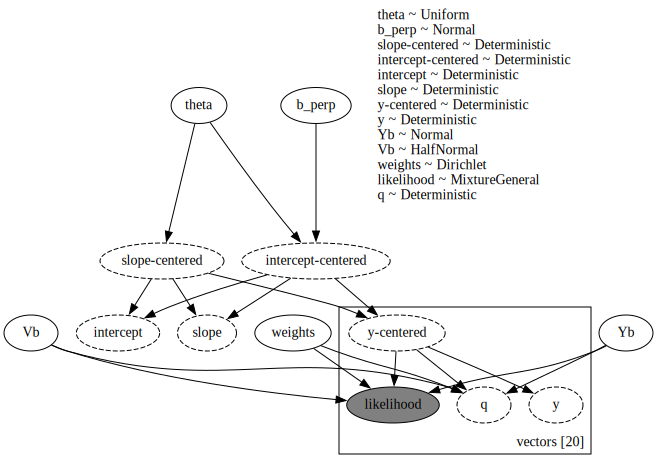

In [12]:
def mdl_signoise():
    theta = numpyro.sample('theta', dist.Uniform(-0.5 * jnp.pi, 0.5 * jnp.pi))
    b_perp = numpyro.sample('b_perp', dist.Normal(0.0, 10.0))
    b1 = numpyro.deterministic('slope-centered', jnp.tan(theta))
    b0 = numpyro.deterministic('intercept-centered', b_perp / jnp.cos(theta))

    # b0 = numpyro.sample('intercept-centered', dist.Normal(loc=0, scale=100)
    # b1 = numpyro.sample('slope-centered', dist.Normal(loc=1, scale=100))

    # un-center slope and intercept as Deterministic variables so we can plot them later
    b0_orig, b1_orig = un_center(b0, b1, x_mean, x_std, y_mean, y_std)
    numpyro.deterministic('intercept', b0_orig)
    numpyro.deterministic('slope', b1_orig)

    with numpyro.plate(f'vectors [{len(y_center)}]', len(y_center)):
        y_est_centered = numpyro.deterministic('y-centered', b0 + b1 * x_center)
        # un-center y_est for plotting later on
        numpyro.deterministic('y', (y_est_centered * y_std) + y_mean)

    # foreground distribution
    fg_dist = dist.Normal(y_est_centered, sy_center)

    # Define weakly informative priors for the mean and variance of the outliers
    Yb = numpyro.sample('Yb', dist.Normal(0, 10))
    Vb = numpyro.sample('Vb', dist.HalfNormal(3))

    # background distribution
    bg_dist = dist.Normal(Yb, jnp.sqrt(Vb + sy_center**2))

    weights = numpyro.sample('weights', dist.Dirichlet(jnp.array([0.5, 0.5])))
    
    mix_categories = dist.Categorical(probs=weights)
    mixture = dist.Mixture(mix_categories, [bg_dist, fg_dist])
    with numpyro.plate(f'vectors [{len(y_center)}]', len(y_center)):
        y_ = numpyro.sample('likelihood', mixture, obs=y_center)

        log_probs = mixture.component_log_probs(y_)
        numpyro.deterministic(
            'q', jnp.exp(log_probs - jax.nn.logsumexp(log_probs, axis=-1, keepdims=True))
        )


numpyro.render_model(mdl_signoise, render_distributions=True)


In [13]:
# Rotate the random seed
rng_key, rng_key_ = jax.random.split(rng_key)

kernel = infer.NUTS(mdl_signoise, init_strategy=infer.init_to_median(), target_accept_prob=0.99)
mcmc = infer.MCMC(kernel, num_warmup=1000, num_samples=2000, num_chains=4)
mcmc.run(rng_key_)


  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

If you see any divergent chains it typically means one or more of your priors are not set to reasonable distributions, some of your parameters have high covariance and should be rescaled, or you need to increase `target_accept_prob` from its default of 0.8 to 0.99 avoid divergent chains.

### Note about priors
Often times the priors you use will effect how fast the sampler will run.  If you are getting a small number of it/s try changing all your priors to `Normal` distributions to see if it runs any faster (`Uniform` priors can be very slow if they cover a large range).

See https://github.com/stan-dev/stan/wiki/Prior-Choice-Recommendations for other tips about picking priors.

### Check for convergence

divergences: 0


mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
intercept-centered  0.032  0.060  -0.076    0.150      0.001    0.001   
slope-centered      1.237  0.063   1.118    1.352      0.001    0.001   
Vb                  1.654  1.278   0.104    4.017      0.018    0.013   
Yb                  0.278  0.681  -0.953    1.642      0.011    0.009   
weights[0]          0.260  0.124   0.050    0.482      0.001    0.001   
weights[1]          0.740  0.124   0.518    0.950      0.001    0.001   

                    ess_bulk  ess_tail  r_hat  
intercept-centered    7421.0    4931.0    1.0  
slope-centered        7153.0    4884.0    1.0  
Vb                    4800.0    4581.0    1.0  
Yb                    4276.0    3517.0    1.0  
weights[0]            7397.0    4965.0    1.0  
weights[1]            7397.0    4965.0    1.0

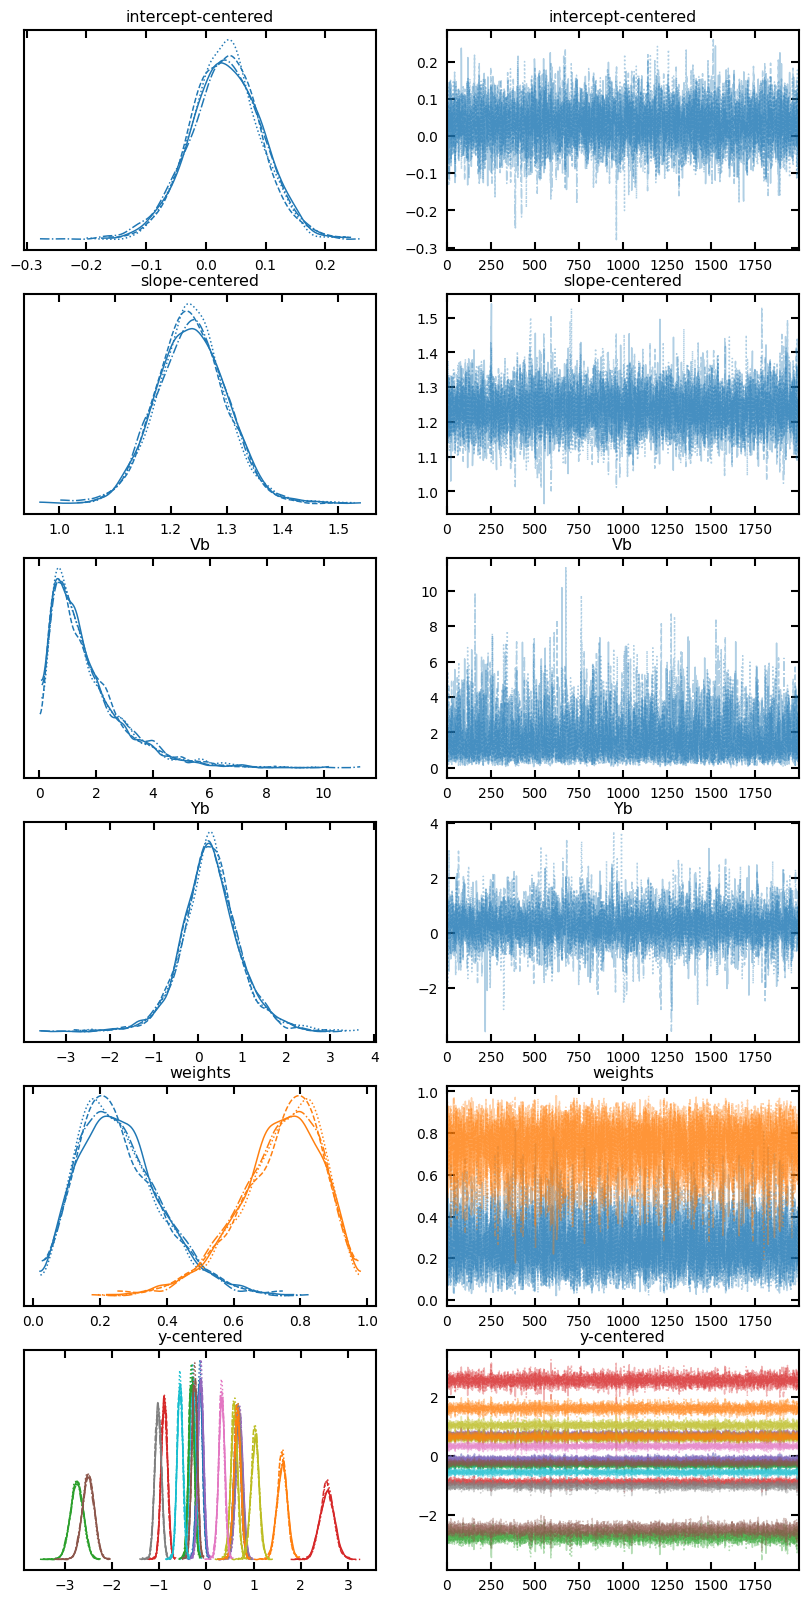

In [14]:
traces_signoise = arviz.from_numpyro(mcmc)

print(f'divergences: {traces_signoise.sample_stats.diverging.values.sum()}')

display(arviz.summary(
    traces_signoise,
    var_names=[
        'intercept-centered',
        'slope-centered',
        'Vb',
        'Yb',
        'weights'
    ]
))
arviz.plot_trace(
    traces_signoise,
    var_names=[
        'intercept-centered',
        'slope-centered',
        'Vb',
        'Yb',
        'weights',
        'y-centered'
    ],
    figsize=(10, 20)
);


As before we can see the `Rhat` values are all close to 1 and all the chains are well mixed.

Lets take a look at a corner plot of these fit variables after converting the slope and intercept back into the original data space.

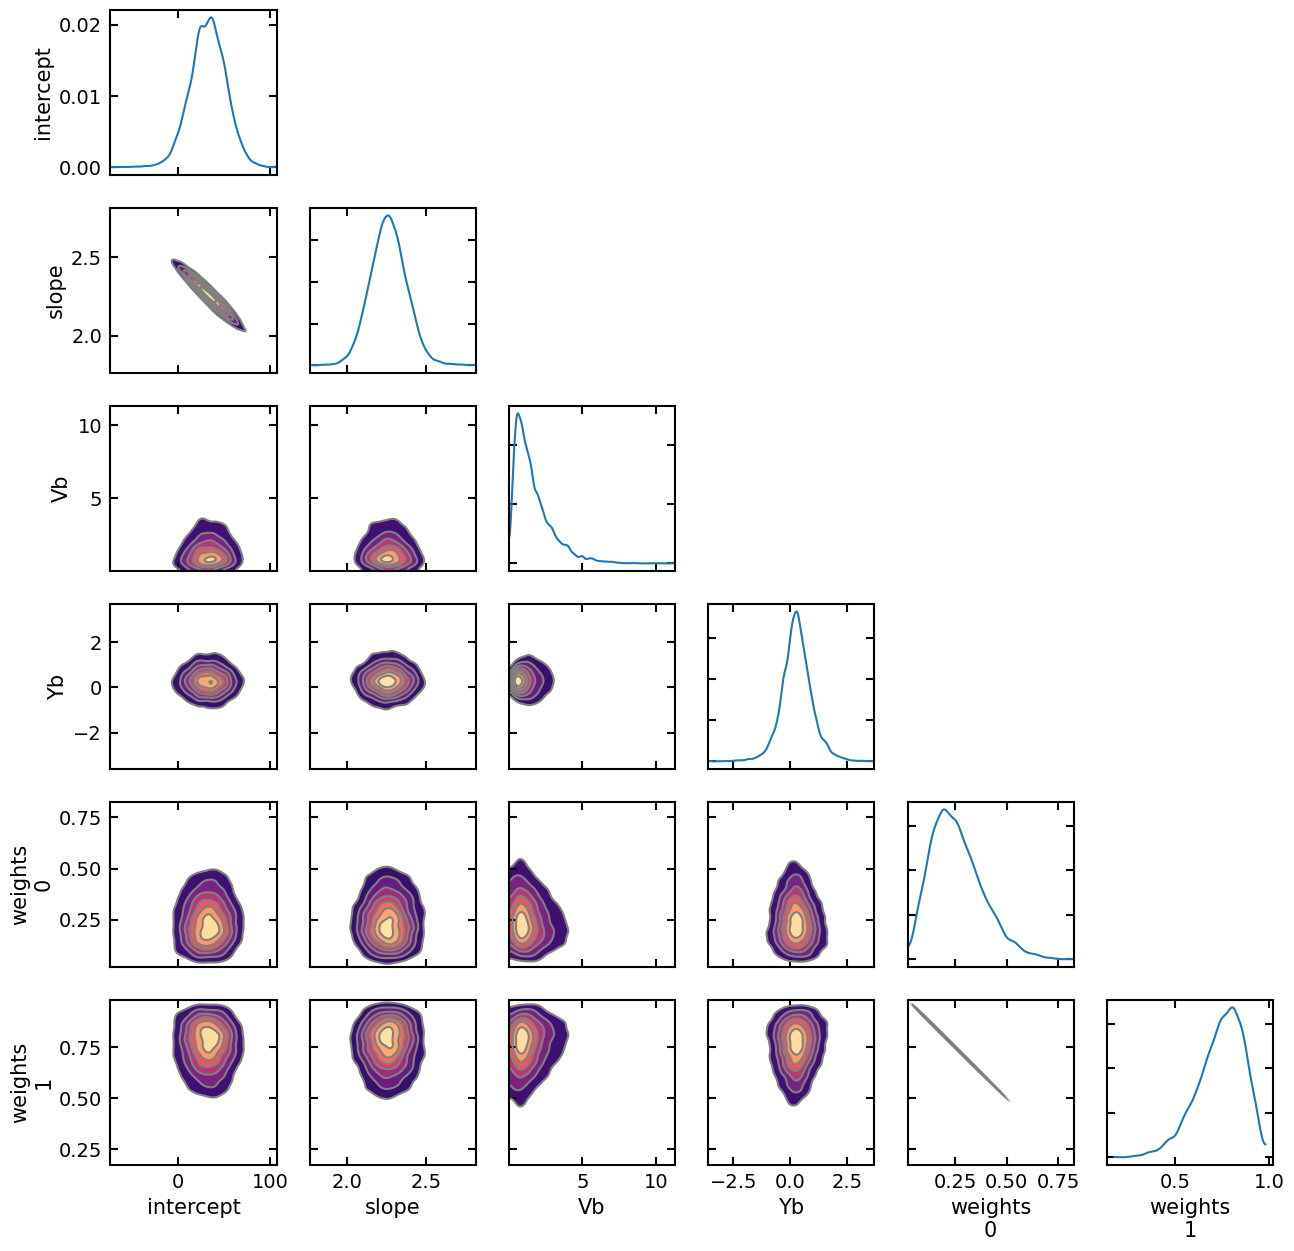

In [15]:
ax = arviz.plot_pair(
    traces_signoise,
    var_names=['intercept', 'slope', 'Vb', 'Yb', 'weights'],
    marginals=True,
    kind='kde',
    figsize=[15, 15]
)


As before we see a strong correlation between the slope and intercept.

### Finding the outliers
Unlike the OLS fit, this fit also has information about the probability of each point being an outlier ($q_i$).  Averaging these across each step and chin gives us the probability of each point being an outlier.

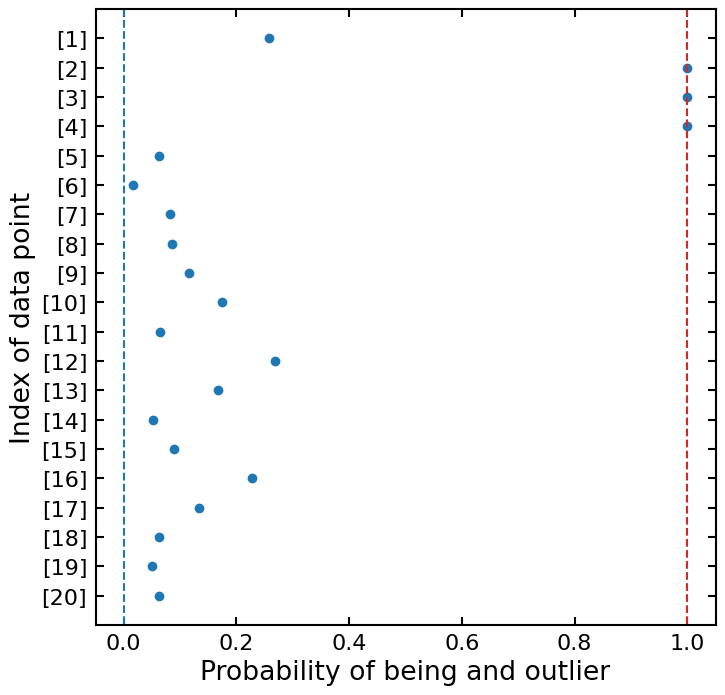

In [16]:
plt.figure(3, figsize=(8, 8))
avg_q = traces_signoise.posterior.q.mean(dim=['chain', 'draw'])[:, 0].data

plt.plot(avg_q, range(20), 'o')
plt.vlines([0, 1], -1, 20, ['C0', 'C3'], '--')
ax=plt.gca()
ax.set_yticks(range(20))
ax.set_yticklabels(['[{0}]'.format(i) for i in data.ID])
plt.xlabel('Probability of being and outlier')
plt.ylabel('Index of data point')
plt.ylim(20, -1);


From this plot we can see that three points are clearly marked as being outliers 100% of the time.  All of the other points are classed as outliers less that 33% of the time.

Lets take a closer look at the posterior distribution for the fraction of data points belonging to the outlier distribution ($weights$).  Looking at the above plot we might expect this to peak at $3/20 = 0.15$. 

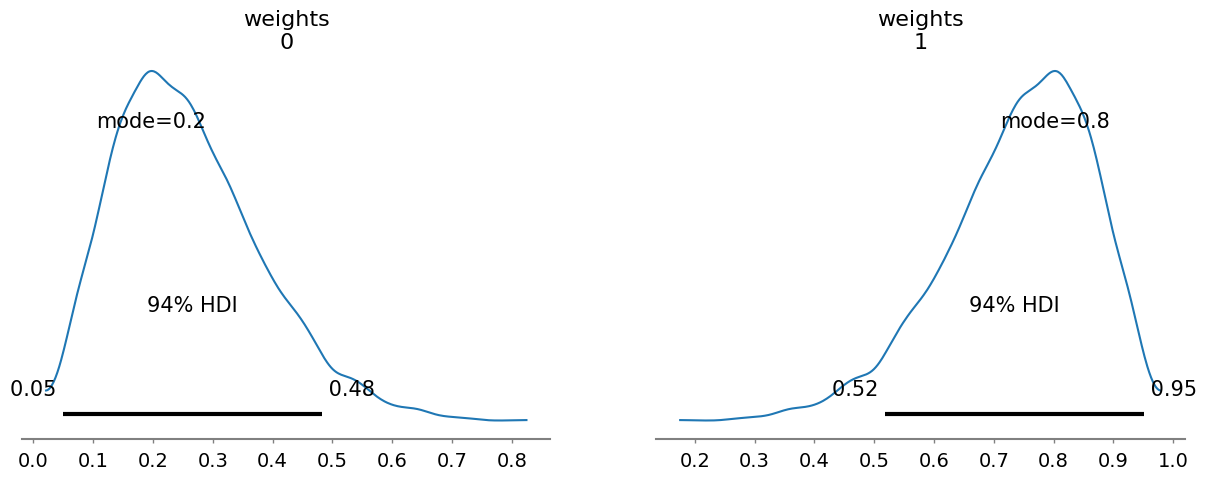

In [17]:
arviz.plot_posterior(
    traces_signoise,
    var_names=['weights'],
    figsize=(15, 5),
    point_estimate='mode'
);


Interestingly it peaks at 0.2, so we would expect 4 to 5 outliers instead of 3, so where does this number come from?

In [18]:
avg_q.mean()


0.24867392

That is closer to the peak of the posterior.  This is taking the sum of the outlier fraction for *all* points into account.  So overall there are "5" outliers but 2 of those are split among 17 data points.

### Plotting the fits
As before lets plot these fits on the original data points but this time we will highlight the outliers.

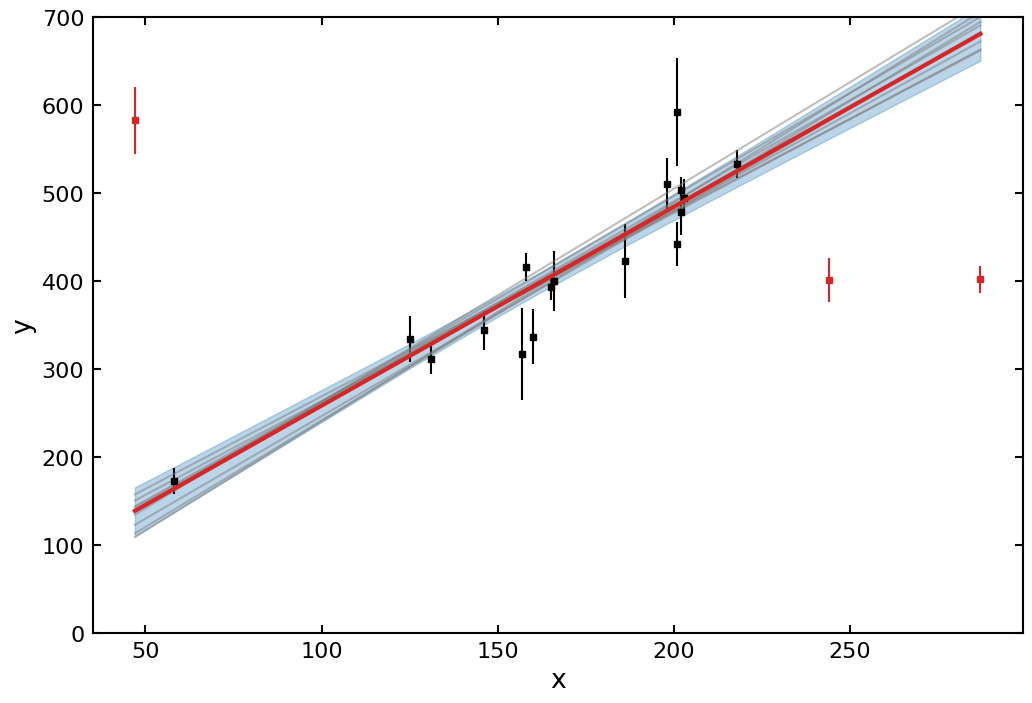

In [19]:
y_est = traces_signoise.posterior.y.data.reshape(-1, 20)

# find the outliers
outliers = avg_q > 0.8

plt.figure(4, figsize=(12, 8))
# plot inliers
plt.errorbar(data.x[~outliers], data.y[~outliers], data.sy[~outliers], **errorbar_kwargs)

# plot outliers
plt.errorbar(
    data.x[outliers],
    data.y[outliers],
    data.sy[outliers],
    ls='None',
    mfc='C3',
    mec='C3',
    ms=5,
    marker='s',
    ecolor='C3'
)

y_est_minus_2_sigma, y_est_median, y_est_plus_2_sigma = np.percentile(
    y_est[:, idx],
    [2.5, 50, 97.5],
    axis=0
)

# plot the mean of all best fit lines
plt.plot(data.x[idx], y_est_median, color='C3', lw=3, zorder=3)

# plot 2-sigma best fit region
plt.fill_between(data.x[idx], y_est_minus_2_sigma, y_est_plus_2_sigma, **fill_kwargs)

# plot a selection of best fit lines
plt.plot(data.x[idx], y_est[::800].T[idx], alpha=0.5, color='C7')

plt.xlabel('x')
plt.ylabel('y')
plt.ylim(0, 700);


Looking much better!  Our best fit line goes through all the data points without being confused by the outliers.

## How to deal with errors in the $x$ direction

Up until now we have only taken into account the errorbars in the $y$ direction. If you also wanted to account for the errors in the $x$ direction (assuming there are no covariances) the OLS model would look like this:

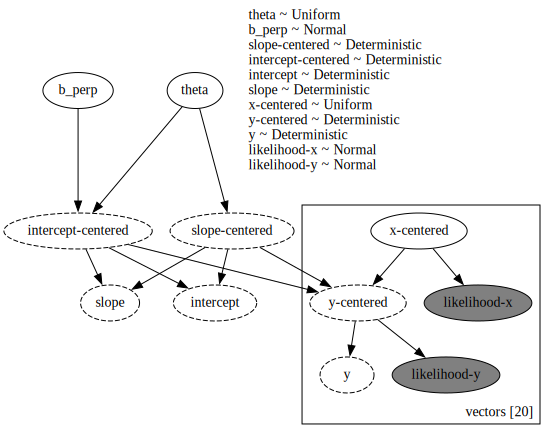

In [20]:
def mdl_ols_sx():
    # Define weakly informative Normal priors (Ridge regression)
    theta = numpyro.sample('theta', dist.Uniform(-0.5 * jnp.pi, 0.5 * jnp.pi))
    b_perp = numpyro.sample('b_perp', dist.Normal(0.0, 10.0))
    b1 = numpyro.deterministic("slope-centered", jnp.tan(theta))
    b0 = numpyro.deterministic("intercept-centered", b_perp / jnp.cos(theta))

    # un-center slope and intercept as Deterministic variables so we can plot them later
    b0_orig, b1_orig = un_center(b0, b1, x_mean, x_std, y_mean, y_std)
    numpyro.deterministic('intercept', b0_orig)
    numpyro.deterministic('slope', b1_orig)

    with numpyro.plate(f'vectors [{len(y_center)}]', len(x_center)):
        x_est_centered = numpyro.sample('x-centered', dist.Uniform(-5, 5))
        y_est_centered = numpyro.deterministic('y-centered', b0 + b1 * x_est_centered)
        # un-center y_est for plotting later on
        numpyro.deterministic('y', (y_est_centered * y_std) + y_mean)

        # Likelihood
        numpyro.sample('likelihood-x', dist.Normal(x_est_centered, sx_center), obs=x_center)
        numpyro.sample('likelihood-y', dist.Normal(y_est_centered, sy_center), obs=y_center)

numpyro.render_model(mdl_ols_sx, render_distributions=True)


This looks much like the model before, except this time we assume a `Uniform` prior on the $x$ positions and add in a second likelihood using the observed $x$ data.

In [21]:
# Rotate the random seed
rng_key, rng_key_ = jax.random.split(rng_key)

kernel = infer.NUTS(mdl_ols_sx, init_strategy=infer.init_to_median(), target_accept_prob=0.95)
mcmc = infer.MCMC(kernel, num_warmup=1000, num_samples=1000, num_chains=4)
mcmc.run(rng_key_)


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

divergences: 0


mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
intercept-centered -0.164  0.050  -0.261   -0.072      0.001    0.001   
slope-centered      0.703  0.052   0.608    0.802      0.001    0.001   

                    ess_bulk  ess_tail  r_hat  
intercept-centered    5236.0    3172.0    1.0  
slope-centered        4326.0    3463.0    1.0

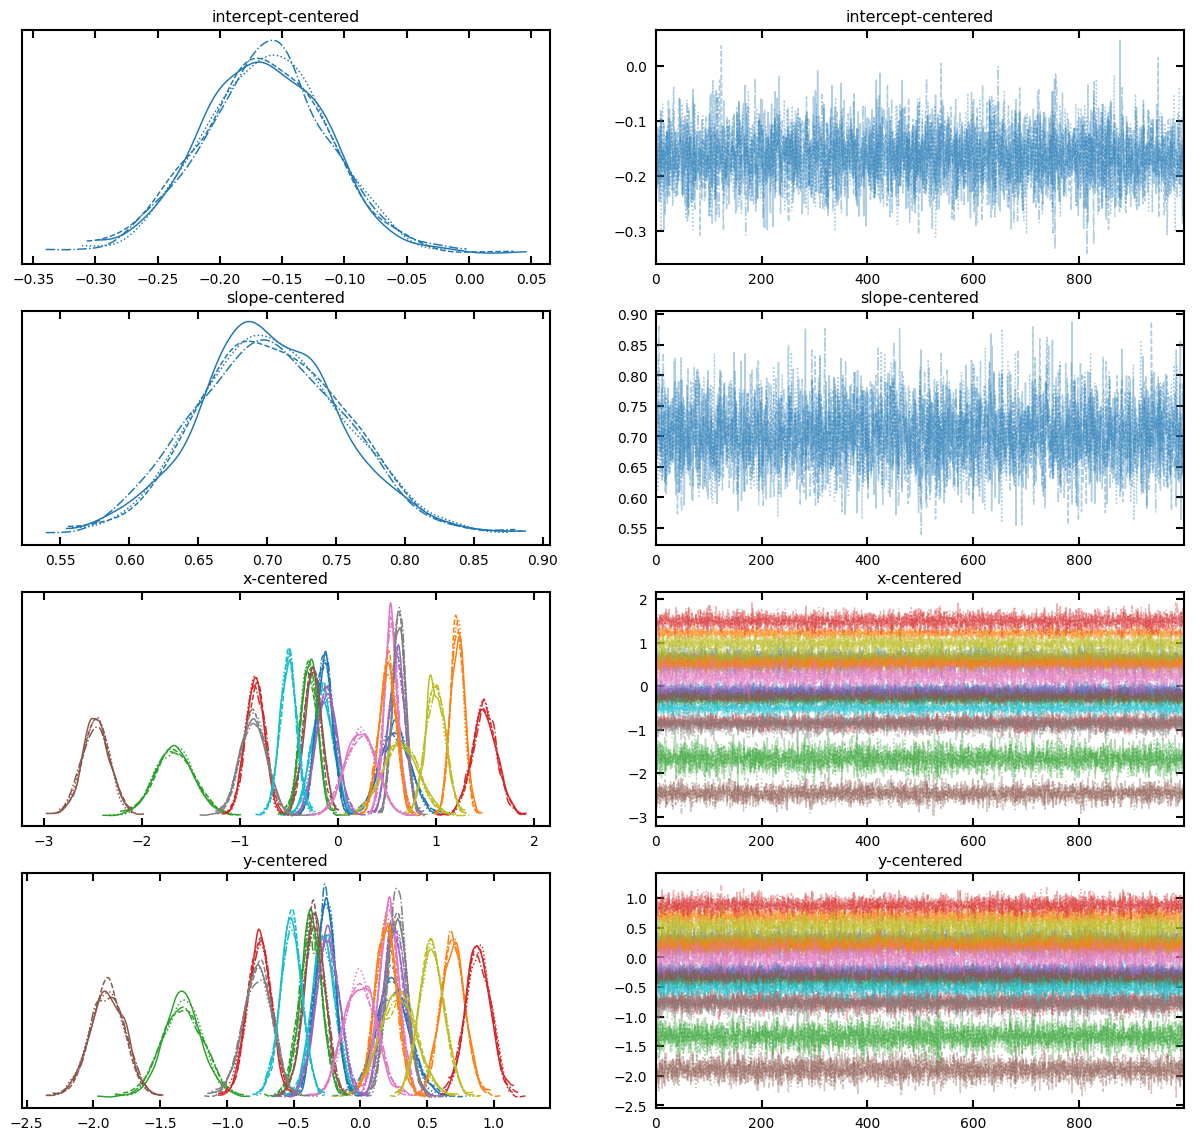

In [22]:
traces_ols_2 = arviz.from_numpyro(mcmc)

print(f'divergences: {traces_ols_2.sample_stats.diverging.values.sum()}')

display(arviz.summary(
    traces_ols_2,
    var_names=[
        'intercept-centered',
        'slope-centered'
    ]
))
arviz.plot_trace(
    traces_ols_2,
    var_names=[
        'intercept-centered',
        'slope-centered',
        'x-centered',
        'y-centered'
    ],
    figsize=(15, 14)
);


Care should be taken when plotting these results as each $y_{est}$ has been calculated using slightly different $x_{est}$ values, so they can't be averaged as nicely as before.

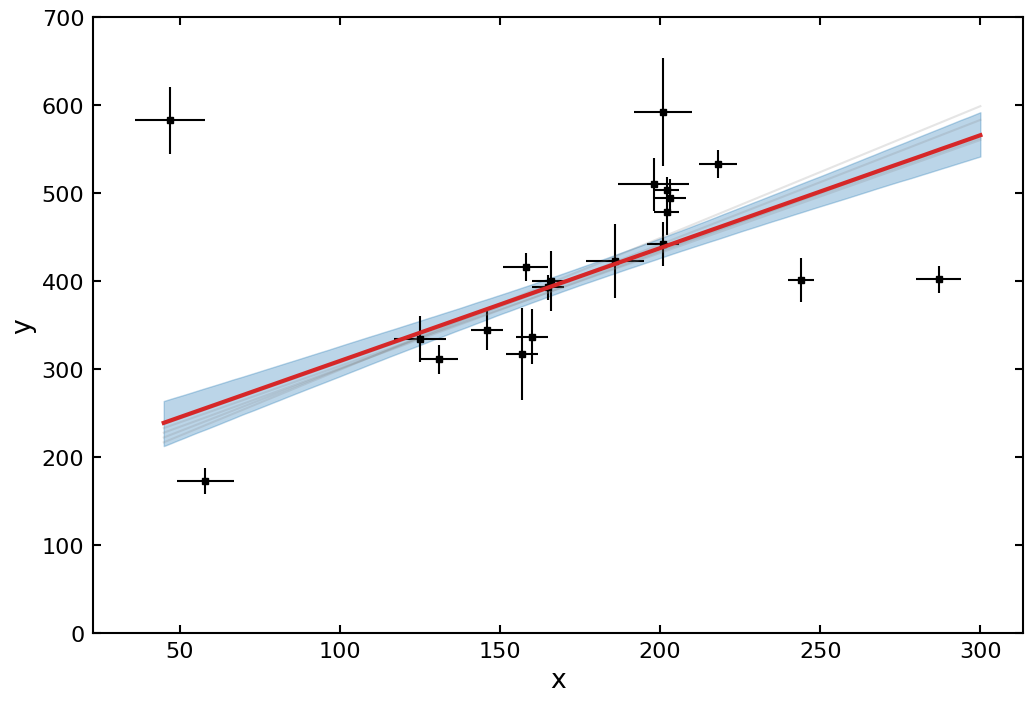

In [23]:
# get y_est evaluated at all the same x positions
x_eval = np.linspace(45, 300, 200)
y_eval = traces_ols_2.posterior.slope.data.reshape(-1, 1) * x_eval + traces_ols_2.posterior.intercept.data.reshape(-1, 1)

# get 2-sigma region and median
y_est_minus_2_sigma, y_est_median, y_est_plus_2_sigma = np.percentile(
    y_eval,
    [2.5, 50, 97.5],
    axis=0
)

plt.figure(5, figsize=(12, 8))
plt.errorbar(data.x, data.y, data.sy, data.sx, **errorbar_kwargs)

# plot the mean of all best fit lines
plt.plot(x_eval, y_est_median, color='C3', lw=3, zorder=3)

# plot 2-sigma best fit region
plt.fill_between(x_eval, y_est_minus_2_sigma, y_est_plus_2_sigma, **fill_kwargs)

# plot a selection of best fit lines
plt.plot(x_eval, y_eval[::800].T, alpha=0.2, color='C7')

plt.xlabel('x')
plt.ylabel('y')
plt.ylim(0, 700);


A similar setup can be used as in the mixture model above to account for outliers.

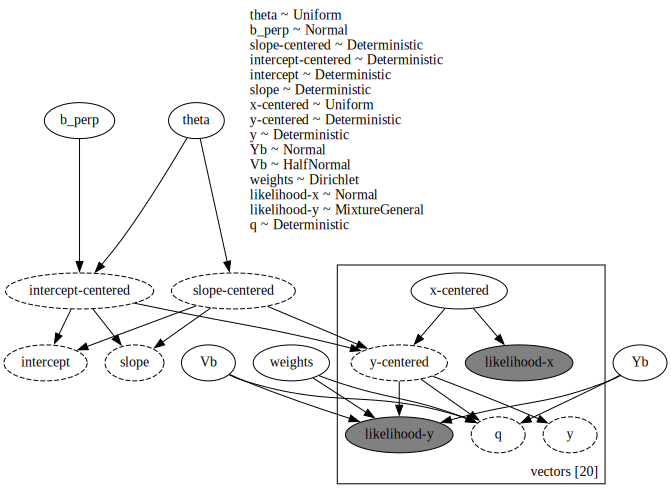

In [24]:
def mdl_all():
    # Define weakly informative Normal priors (Ridge regression)
    theta = numpyro.sample('theta', dist.Uniform(-0.5 * jnp.pi, 0.5 * jnp.pi))
    b_perp = numpyro.sample('b_perp', dist.Normal(0.0, 10.0))
    b1 = numpyro.deterministic("slope-centered", jnp.tan(theta))
    b0 = numpyro.deterministic("intercept-centered", b_perp / jnp.cos(theta))

    # un-center slope and intercept as Deterministic variables so we can plot them later
    b0_orig, b1_orig = un_center(b0, b1, x_mean, x_std, y_mean, y_std)
    numpyro.deterministic('intercept', b0_orig)
    numpyro.deterministic('slope', b1_orig)

    with numpyro.plate(f'vectors [{len(y_center)}]', len(x_center)):
        x_est_centered = numpyro.sample('x-centered', dist.Uniform(-5, 5))
        y_est_centered = numpyro.deterministic('y-centered', b0 + b1 * x_est_centered)
        # un-center y_est for plotting later on
        numpyro.deterministic('y', (y_est_centered * y_std) + y_mean)
    
    # foreground distribution
    fg_dist = dist.Normal(y_est_centered, sy_center)
    
    # Define weakly informative priors for the mean and variance of the outliers
    Yb = numpyro.sample('Yb', dist.Normal(0, 10))
    Vb = numpyro.sample('Vb', dist.HalfNormal(3))

    # background distribution
    bg_dist = dist.Normal(Yb, jnp.sqrt(Vb + sy_center**2))

    weights = numpyro.sample('weights', dist.Dirichlet(jnp.array([0.5, 0.5])))
    
    mix_categories = dist.Categorical(probs=weights)
    mixture = dist.Mixture(mix_categories, [bg_dist, fg_dist])

    with numpyro.plate(f'vectors [{len(y_center)}]', len(x_center)):
        # Likelihood
        numpyro.sample('likelihood-x', dist.Normal(x_est_centered, sx_center), obs=x_center)
        y_ = numpyro.sample('likelihood-y', mixture, obs=y_center)
        
        log_probs = mixture.component_log_probs(y_)
        numpyro.deterministic(
            'q', jnp.exp(log_probs - jax.nn.logsumexp(log_probs, axis=-1, keepdims=True))
        )

numpyro.render_model(mdl_all, render_distributions=True)


In [25]:
# Rotate the random seed
rng_key, rng_key_ = jax.random.split(rng_key)

kernel = infer.NUTS(mdl_all, init_strategy=infer.init_to_median(), target_accept_prob=0.99)
mcmc = infer.MCMC(kernel, num_warmup=1000, num_samples=2000, num_chains=4)
mcmc.run(rng_key_)


  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

divergences: 0


mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
intercept-centered  0.009  0.070  -0.118    0.140      0.001    0.001   
slope-centered      1.251  0.094   1.082    1.430      0.001    0.001   
Vb                  1.687  1.320   0.095    4.165      0.015    0.012   
Yb                  0.307  0.689  -0.961    1.728      0.008    0.008   
weights[0]          0.253  0.119   0.051    0.468      0.001    0.001   
weights[1]          0.747  0.119   0.532    0.949      0.001    0.001   

                    ess_bulk  ess_tail  r_hat  
intercept-centered    8793.0    6841.0    1.0  
slope-centered        7893.0    6375.0    1.0  
Vb                    9234.0    6154.0    1.0  
Yb                    8986.0    4287.0    1.0  
weights[0]           11625.0    5346.0    1.0  
weights[1]           11625.0    5346.0    1.0

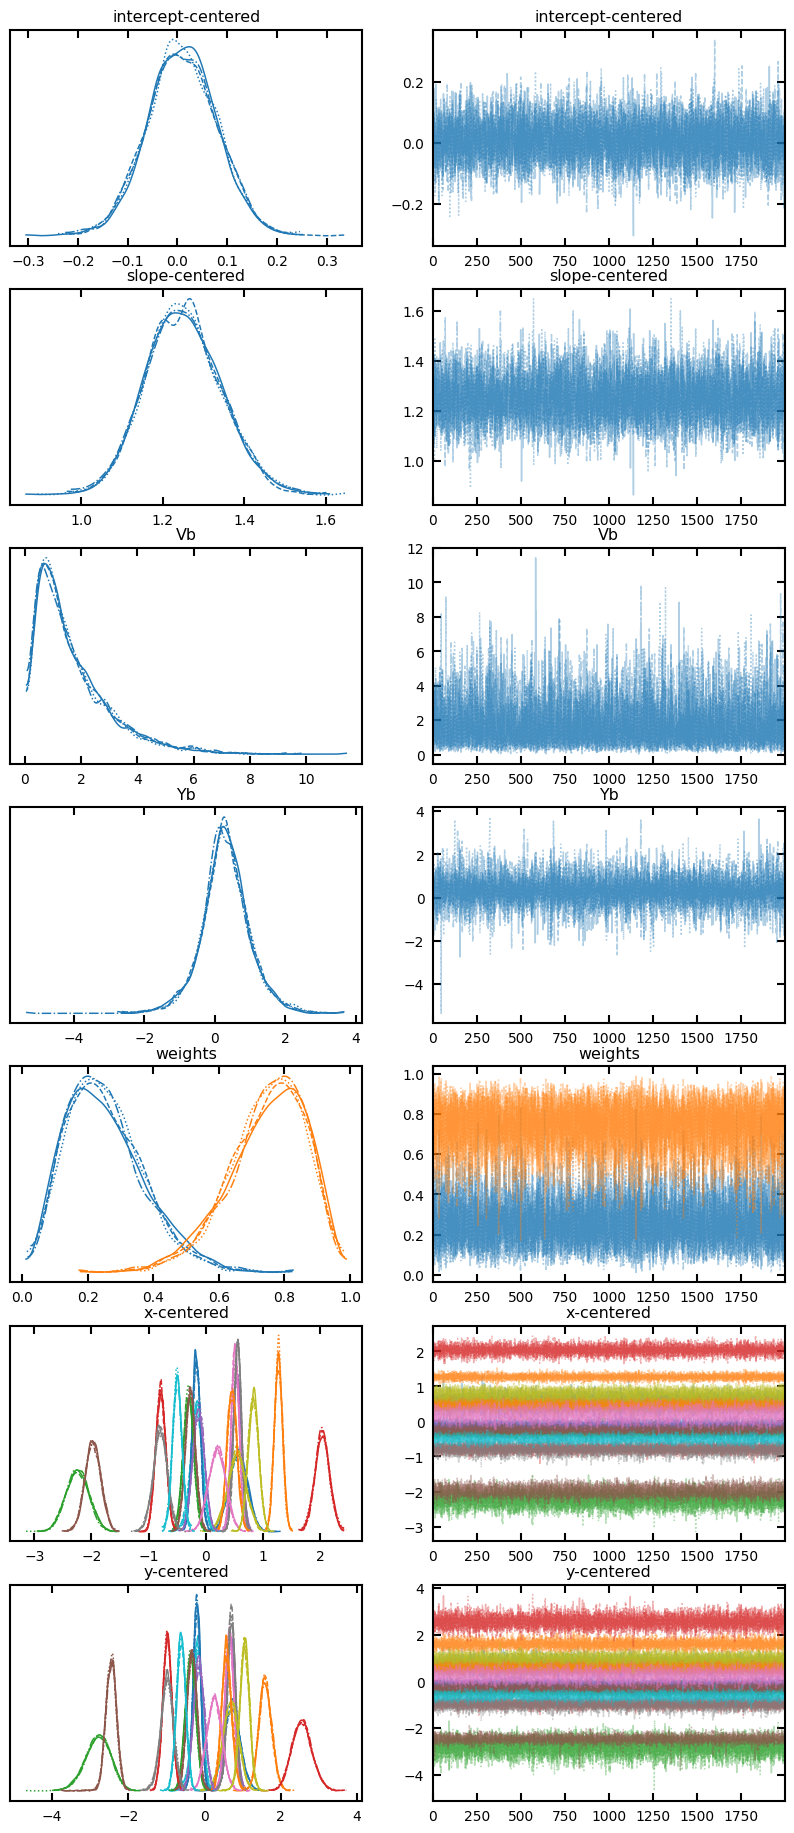

In [26]:
traces_all = arviz.from_numpyro(mcmc)

print(f'divergences: {traces_all.sample_stats.diverging.values.sum()}')

display(arviz.summary(
    traces_all,
    var_names=[
        'intercept-centered',
        'slope-centered',
        'Vb',
        'Yb',
        'weights'
    ]
))
arviz.plot_trace(
    traces_all,
    var_names=[
        'intercept-centered',
        'slope-centered',
        'Vb',
        'Yb',
        'weights',
        'x-centered',
        'y-centered'
    ],
    figsize=(10, 23)
);


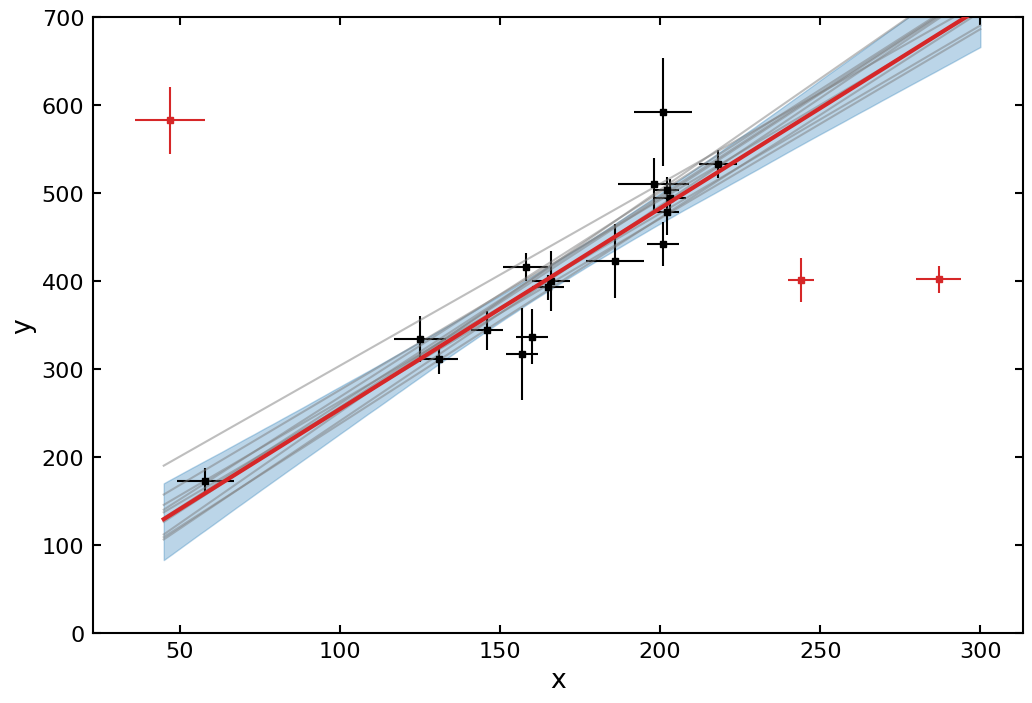

In [27]:
avg_q = traces_all.posterior.q.mean(dim=['chain', 'draw'])[:, 0].data

# evaluate all lines on the same x-values
x_eval = np.linspace(45, 300, 200)
y_eval = traces_all.posterior.slope.data.reshape(-1, 1) * x_eval + traces_all.posterior.intercept.data.reshape(-1, 1)

# find the outliers
outliers = avg_q > 0.8

plt.figure(4, figsize=(12, 8))
# plot inliers
plt.errorbar(data.x[~outliers], data.y[~outliers], data.sy[~outliers], data.sx[~outliers], **errorbar_kwargs)

# plot outliers
plt.errorbar(
    data.x[outliers],
    data.y[outliers],
    data.sy[outliers],
    data.sx[outliers],
    ls='None',
    mfc='C3',
    mec='C3',
    ms=5,
    marker='s',
    ecolor='C3'
)

y_est_minus_2_sigma, y_est_median, y_est_plus_2_sigma = np.percentile(
    y_eval,
    [2.5, 50, 97.5],
    axis=0
)

# plot the mean of all best fit lines
plt.plot(x_eval, y_est_median, color='C3', lw=3, zorder=3)

# plot 2-sigma best fit region
plt.fill_between(x_eval, y_est_minus_2_sigma, y_est_plus_2_sigma, **fill_kwargs)

# plot a selection of best fit lines
plt.plot(x_eval, y_eval[::800].T, alpha=0.5, color='C7')

plt.xlabel('x')
plt.ylabel('y')
plt.ylim(0, 700);
